In [81]:
import math
import numpy as np 
import pandas as pd
import xgboost
import sklearn

import matplotlib.pyplot as plt #Matplotlib for Viz
import seaborn as sns #Seaborn for Viz
from scipy import stats #Outlier Analysis & Removal
import plotly.graph_objects as go #Plotly for Viz
import plotly.express as px # Plotly express
from plotly.subplots import make_subplots

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler #Scaling variables
from sklearn.model_selection import train_test_split
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier #RF, GB
from sklearn.metrics import f1_score, log_loss, confusion_matrix 
from sklearn.multioutput import MultiOutputClassifier
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA 

from xgboost import XGBClassifier

In [5]:
# reading data files and storing them in a dataframe
df_train_features = pd.read_csv('C:/Users/hp/Desktop/EAI 6000 Project/lish-moa/train_features.csv')
df_test_features = pd.read_csv('C:/Users/hp/Desktop/EAI 6000 Project/lish-moa/test_features.csv')
df_train_target_nonscored = pd.read_csv('C:/Users/hp/Desktop/EAI 6000 Project/lish-moa/train_targets_nonscored.csv')
df_train_target_scored = pd.read_csv('C:/Users/hp/Desktop/EAI 6000 Project/lish-moa/train_targets_scored.csv')


In [6]:
selected = df_train_features['cp_type'] == 'trt_cp'
df_train_features = df_train_features[selected].drop('cp_type', 1)

df_train_features['cp_dose'] = df_train_features['cp_dose'] == 'D1'

selected_test = df_test_features['cp_type'] == 'trt_cp'

df_train_target_scored = pd.read_csv('C:/Users/hp/Desktop/EAI 6000 Project/lish-moa/train_targets_scored.csv')[selected]
df_test_features = df_test_features.drop('cp_type', 1)

df_test_features['cp_dose'] = df_test_features['cp_dose'] == 'D1'


In [7]:
np.sum(df_train_features.iloc[:, 1:].values, axis = 0)

array([1053840, 11196, 6094.410200000001, -1752.4431000000097,
       3695.8482000000045, 1783.5998000000004, 1865.0048999999938,
       -3146.9475000000184, 266.13059999999786, -4484.669000000035,
       -5264.554200000021, 2288.761799999978, -2940.4546999999834,
       4451.416700000054, 2363.5914000000166, 4686.6018,
       -4191.924499999988, -407.70599999999865, 2274.205500000007,
       -3858.5677999999875, 2154.5001000000034, -1626.1501000000053,
       -3169.195000000006, -1642.8664999999964, 1585.1015999999888,
       -2543.0508000000013, -2788.2387999999946, -1704.0827999999908,
       -2977.251599999985, 3226.809599999973, -1907.22570000001,
       -1599.3519000000083, -4772.47010000001, 8827.050600000015,
       -4147.388099999996, 1088.6721000000073, -1563.7459999999926,
       2937.1383, -4338.137600000014, -14569.792199999985,
       12979.364900000013, 4004.547800000011, -4894.403700000058,
       -3473.847200000014, -2442.9782999999798, 602.6104000000037,
       -555.5

In [8]:
X = df_train_features.iloc[:, 1:]
easy_cat = []
for category in df_train_target_scored.columns[1:]:
    tg = df_train_target_scored[category]
    total = tg.sum()
    if total > 100: 
        continue
    depth = int(total/2)+1
    score = 0
    for cr in ['gini', 'entropy']:
        tree = DecisionTreeClassifier(criterion = cr, max_depth = depth)
        tree.fit(X, tg)
        score = max(score, f1_score(tg, tree.predict(X)))
        print(f'best score for {category} (size - {total}) = {f1_score(tg, tree.predict(X))} on criterion {cr} with depth = {depth}')
        if score == 1:
            easy_cat.append((category, cr, tree.get_depth(),total))
            print()
            break
    print()

best score for 5-alpha_reductase_inhibitor (size = 17) = 0.7857142857142858 on criterion gini with depth = 9
best score for 5-alpha_reductase_inhibitor (size = 17) = 1.0 on criterion entropy with depth = 9


best score for 11-beta-hsd1_inhibitor (size = 18) = 0.7142857142857143 on criterion gini with depth = 10
best score for 11-beta-hsd1_inhibitor (size = 18) = 0.4347826086956522 on criterion entropy with depth = 10

best score for acat_inhibitor (size = 24) = 0.7027027027027027 on criterion gini with depth = 13
best score for acat_inhibitor (size = 24) = 1.0 on criterion entropy with depth = 13


best score for acetylcholinesterase_inhibitor (size = 73) = 0.8769230769230769 on criterion gini with depth = 37
best score for acetylcholinesterase_inhibitor (size = 73) = 1.0 on criterion entropy with depth = 37


best score for adenosine_receptor_agonist (size = 54) = 0.8979591836734693 on criterion gini with depth = 28
best score for adenosine_receptor_agonist (size = 54) = 1.0 on criter

In [14]:
ct = [c[0] for c in easy_cat]
cr = [c[1] for c in easy_cat]
d = [c[2] for c in easy_cat]
s = [c[3] for c in easy_cat]

easy = pd.DataFrame({
    'categories': ct,
    'positive samples in dataset': s,
    'criterion is': cr,
    'with depth': d
})


easy.to_csv('light_categories.csv', index = False)

easy.sort_values(['positive samples in dataset', 'with depth'])

,categories,positive samples in dataset,criterion is,with depth
7,aldehyde_dehydrogenase_inhibitor,7,entropy,4
29,bacterial_membrane_integrity_inhibitor,7,entropy,4
21,atp_synthase_inhibitor,12,gini,4
5,adenylyl_cyclase_activator,12,entropy,6
86,nitric_oxide_production_inhibitor,12,entropy,6
...,...,...,...,...
4,adenosine_receptor_antagonist,96,entropy,15
90,opioid_receptor_antagonist,96,entropy,21
24,aurora_kinase_inhibitor,96,gini,27
22,atpase_inhibitor,97,gini,48


In [27]:
sub = pd.read_csv('C:/Users/hp/Desktop/EAI 6000 Project/lish-moa/sample_submission.csv')
sub = sub.loc[:, pd.Index(easy['categories'])]

for cat, cr, depth in zip(easy['categories'], easy['criterion is'], easy['with depth']):
    tg = df_train_target_scored[category]
    tree = DecisionTreeClassifier(criterion = cr, max_depth = depth)
    tree.fit(X, tg)
    sub[cat] = tree.predict(df_test_features.iloc[:, 1:])

sub[~selected_test] = 0
sub.to_csv('tree_columns_results.csv', index = False)

In [ ]:
# Random Forest

encode_values = {"cp_type": {"trt_cp": 0, "ctl_vehicle": 1},
                 "cp_time": {24: 0, 48: 1, 72: 2},
                 "cp_dose": {"D1": 0, "D2": 1}}

df_train_features.replace(encode_values, inplace=True)
df_test_features.replace(encode_values, inplace=True)

In [102]:
X_train = df_train_features.iloc[:,1:].to_numpy()
X_test = df_test_features.iloc[:,1:].to_numpy()
y_train = df_train_target_scored.iloc[:,1:].to_numpy()
y_test = df_test_features.iloc[:,1:].to_numpy()

In [43]:
model = RandomForestClassifier(n_estimators=200,max_depth=10, random_state=
                               0,min_samples_split=10)
model.fit(X_train,y_train) 

RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=200,
                       random_state=0)

<AxesSubplot:>

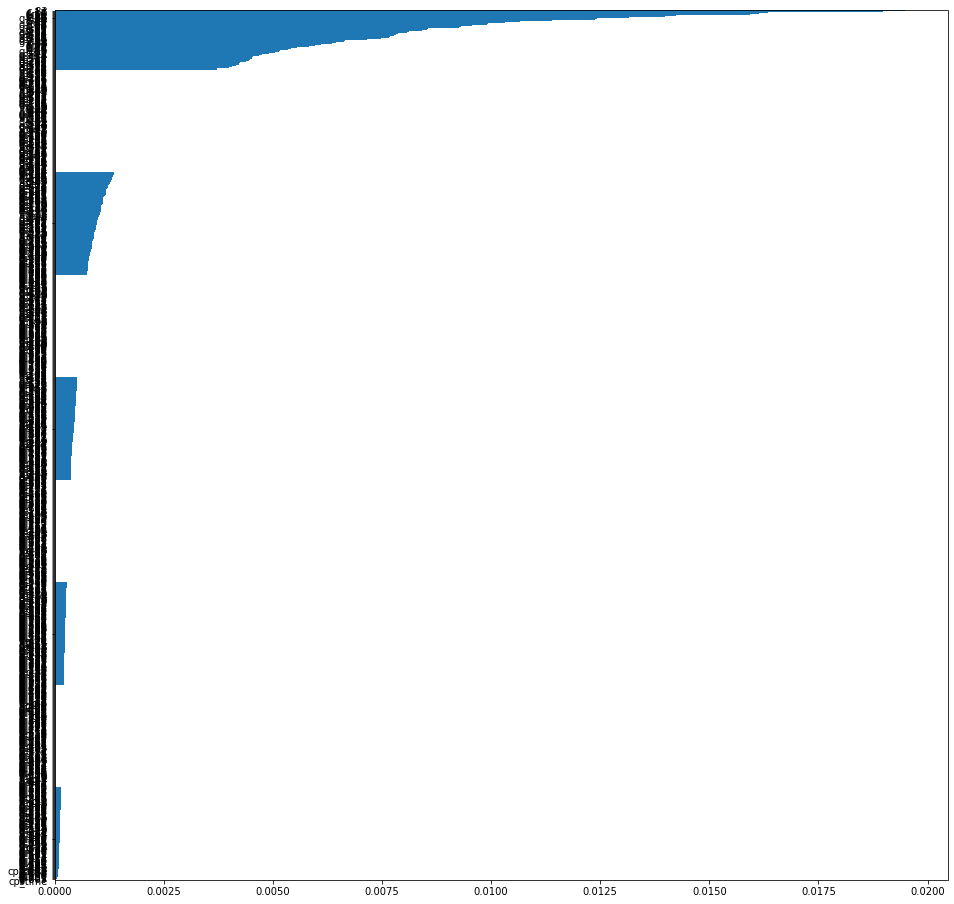

In [56]:
#Generating predictions from Random Forest Models
feature_list=df_train_features.columns

pred_rf=model.predict(X_test)
pred_rf_proba=model.predict_proba(X_test)

feat_importances = pd.Series(model.feature_importances_, index=feature_list[1:])
feat_importances=feat_importances.sort_values()
feat_importances.plot(kind='barh',figsize=(16,16))#Plotting feature importance

In [59]:
import xgboost
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier

xgb = MultiOutputClassifier(XGBClassifier(tree_method='gpu_hist'))

params = {'estimator__colsample_bytree': 0.6522,
          'estimator__gamma': 3.6975,
          'estimator__learning_rate': 0.0503,
          'estimator__max_delta_step': 2.0706,
          'estimator__max_depth': 10,
          'estimator__min_child_weight': 31.5800,
          'estimator__n_estimators': 166,
          'estimator__subsample': 0.8639
         }

xgb.set_params(**params)
xgb.fit(X_train,y_train)

MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.6522,
                                              gamma=3.6975, gpu_id=None,
                                              importance_type='gain',
                                              interaction_constraints=None,
                                              learning_rate=0.0503,
                                              max_delta_step=2.0706,
                                              max_depth=10,
                                              min_child_weight=31.58,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=166, n_jobs=None,
                  

In [116]:
pred_xg_proba = xgb.predict_proba(X_test)
print(pred_xg_proba)

[array([[0.9983288, 0.0016712],
       [0.9983288, 0.0016712],
       [0.9983665, 0.0016335],
       ...,
       [0.9983288, 0.0016712],
       [0.9983665, 0.0016335],
       [0.9983288, 0.0016712]], dtype=float32), array([[0.99835634, 0.00164367],
       [0.99835634, 0.00164367],
       [0.99835634, 0.00164367],
       ...,
       [0.99835634, 0.00164367],
       [0.99835634, 0.00164367],
       [0.99835634, 0.00164367]], dtype=float32), array([[0.9983633 , 0.00163671],
       [0.9983633 , 0.00163671],
       [0.9983633 , 0.00163671],
       ...,
       [0.9983633 , 0.00163671],
       [0.9983633 , 0.00163671],
       [0.9983633 , 0.00163671]], dtype=float32), array([[0.98867464, 0.01132539],
       [0.9922438 , 0.00775618],
       [0.9875028 , 0.01249717],
       ...,
       [0.98903835, 0.01096167],
       [0.9923568 , 0.00764319],
       [0.98857236, 0.01142764]], dtype=float32), array([[0.9905451 , 0.00945492],
       [0.9896224 , 0.01037759],
       [0.9855987 , 0.0144013 ],
    

In [ ]:
grad_boost_classifier = GradientBoostingClassifier(learning_rate=0.01,max_depth=2,random_state=0)
    #title = 'Gradient boosting binary dataset'
   # plot_class_regions_for_classifier_subplot(grad_boost_classifier,X_train,y_train,X_test,y_test,title)
grad_boost_classifier.fit(X_train,y_train)

predicted_values = grad_boost_classifier.predict(X_test)

In [ ]:
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.multioutput import MultiOutputClassifier

In [ ]:
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import callbacks
import keras
from sklearn.metrics import log_loss
from keras.regularizers import L1, L2

In [ ]:
drug = pd.read_csv('C:/Users/hp/Desktop/EAI 6000 Project/lish-moa/train_features.csv')
target = pd.read_csv('C:/Users/hp/Desktop/EAI 6000 Project/lish-moa/train_targets_scored.csv')

# setting the sig_id column as index
drug.set_index('sig_id', inplace= True)
target.set_index('sig_id', inplace= True)

treat_drug = drug.query('cp_type == "trt_cp"')
treat_target = target.loc[treat_drug.index]

In [ ]:
# Getting list of columns names for categorical features, numerical features, gene epxression related features and cell vialbility related features
cat_cols = drug.select_dtypes(include = 'O').columns.tolist()
num_cols = drug.select_dtypes(exclude = 'O').columns.tolist()
gene_features = [i for i in num_cols if i.startswith('g-')]
cell_viability = [i for i in num_cols if i.startswith('c-')]
cat_cols2 = cat_cols + ['cp_time']
num_cols2 = num_cols
num_cols.remove('cp_time')

In [ ]:
# Data prepocesing i.e label encoding 'cp_dose', 'cp_time' and 'cp_type', or whether to drop vehicle/control treated sample rows

qt = QuantileTransformer()

def data_preprocessing(dataframe, only_treatment = True, fit = False, transform = False):
    df = dataframe.copy()
    if fit:
        df[num_cols] = qt.fit_transform(df[num_cols])
    if transform:
        df[num_cols] = qt.transform(df[num_cols])
    df["cp_dose"] = df.cp_dose.map({"D1": 0, "D2":1})
    df["cp_time"] = df.cp_time.map({24: 0,48: 1, 72: 2})
    if only_treatment:
        df = df.drop("cp_type", 1)
    else:
        df["cp_type"] = df.cp_type.map({"trt_cp": 1, "ctl_vehicle":0})
    return df


drug_cleaned = data_preprocessing(dataframe= drug, only_treatment= False, fit= True, transform= False)
drug_treatment = data_preprocessing(dataframe= drug, only_treatment= True,fit= True, transform= False)

In [ ]:
# Defining NN model to be optimized using Optuna hyperparameter optimization:

def for_bayes_optimization2(dimension):
    
    [dl1,dl2,dl3,dl4,dp1,dp2,dp3,dp4,regu,regu_val,activation,learning_rate] = dimension
    if (regu == 'l2'):
        act_reg = keras.regularizers.l2(regu_val)
    if (regu =='l1'):
        act_reg = keras.regularizers.l1(regu_val)
    lr = callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 5, verbose = 0)
    
    #x_train,x_val, y_train, y_val = train_test_split(drug_cleaned, target, test_size = 0.3, random_state = 42)
    es = callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 1e-4, mode = 'min', baseline = 0.3 , 
                                 restore_best_weights=False, patience= 30, verbose = 0)
    
    adam = keras.optimizers.Adam(learning_rate = learning_rate)
    
    model = Sequential()
    model.add(Dense(dl1, input_dim = x_train.shape[1], activation = activation, activity_regularizer = act_reg))
    model.add(Dropout(dp1))
    model.add(Dense(dl2, activation = activation))
    model.add(Dropout(dp2))
    model.add(Dense(dl3, activation = activation))
    model.add(Dropout(dp3))
    model.add(Dense(dl4, activation = activation))
    model.add(Dropout(dp4))
    model.add(Dense(y_train.shape[1], activation = 'sigmoid'))
    
    model.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['AUC'])
    
    model.fit(x = x_train, y = y_train, validation_data = (x_val, y_val), epochs = 200, batch_size = 128, callbacks = [es], verbose = 0)
    
    log_loss_data = log_loss(np.ravel(y_val), np.ravel(model.predict_proba(x_val)), eps = 1e-7) 
    
    return model # or return log_loss_data (for optuna optimization)

In [ ]:
# Best parameters obtained from Optuna 
best_set_from_baysian_optimization = [2048, 1982, 708, 470, 0.6067766671093088, 0.1, 0.4973213653064633, 0.5950996340056243, 'l1', 1e-05, 'swish', 0.0001]

In [ ]:
#Prepartion of sample submission file
submission_test = pd.read_csv('../input/lish-moa/test_features.csv')
submission_test_prob = pd.read_csv('../input/lish-moa/sample_submission.csv')
submission_test_cleaned = data_preprocessing(dataframe= submission_test, only_treatment= False, fit= False, transform= True)
submission_test_prob.set_index('sig_id', inplace= True)
submission_test_cleaned.set_index('sig_id', inplace = True)
submission_test_cleaned

In [ ]:
#setting initial prediction for all to zeros
submission_test_prob[:] = np.zeros(submission_test_prob.shape)
submission_test_prob

In [ ]:
# For submission_File_prediction
n_splits = 5
sub_file = submission_test_cleaned
sub_file_all_predict = np.zeros(submission_test_prob.shape)
nn_loss = [] # neural network loss
xgb_loss = [] # xgb loss
combined_loss = [] # loss of ensembel of NN and XGB
for seed in [10, 20, 30]: # trying three dfiferent seeds

    for e, (train, val) in enumerate(KFold(n_splits = n_splits, shuffle = True, random_state = seed).split(drug_cleaned, target)):
        x_train, y_train = drug_cleaned.iloc[train], target.iloc[train]
        x_val, y_val = drug_cleaned.iloc[val], target.iloc[val]

        model = for_bayes_optimization2(best_set_from_baysian_optimization)
        
        nn_predict = model.predict_proba(x_val)
        
        sub_file_nn_predict = model.predict_proba(sub_file)
        nn_loss_temp = log_loss(np.ravel(y_val), np.ravel(nn_predict), eps = 1e-7)
        nn_loss.append(nn_loss_temp)
        print(f"NN_log_loss fold {e}, seed {seed}: ", nn_loss_temp)
        
        xgb = MultiOutputClassifier(XGBClassifier(tree_method = 'gpu_hist', n_estimators = 130, max_depth = 3, reg_alpha = 2, min_child_weight = 2,
                                             gamma = 3, learning_rate = 0.0580666601841646, colsample_bytree = 0.58)) # Parameters obtained after optimization with Optuna
        xgb.fit(x_train, y_train)
        xgb_predict = np.array(xgb.predict_proba(x_val))[:,:,1].T
        xgb_loss_temp = log_loss(np.ravel(y_val), np.ravel(xgb_predict), eps = 1e-7)
        xgb_loss.append(xgb_loss_temp)
        
        sub_file_xgb_predict = np.array(xgb.predict_proba(sub_file))[:,:,1].T
        avg_sub_file_predict = (sub_file_nn_predict + sub_file_xgb_predict)/2
        
        sub_file_all_predict = sub_file_all_predict + avg_sub_file_predict
        
        combined_loss_temp  = log_loss(np.ravel(y_val), np.ravel((nn_predict + xgb_predict)/2), eps = 1e-7)
        combined_loss.append(combined_loss_temp)
        
        print(f"xgb_log_loss fold {e}, seed {seed}: ", xgb_loss_temp)
        print(f"combined_loss fold {e}, seed {seed}: ", combined_loss_temp)

In [ ]:
print("Average log loss of NN is :", np.mean(nn_loss), " and standard deviation: ", np.std(nn_loss))
print("Average log loss of Xgboost is :", np.mean(xgb_loss), " and standard deviation: ", np.std(xgb_loss))
print("Combined log loss is :", np.mean(combined_loss), " and standard deviation: ", np.std(combined_loss))

In [ ]:
final_predictions = sub_file_all_predict/(n_splits * 3)

In [ ]:
submission_test_prob[:] = final_predictions

In [ ]:
submission_test_prob = np.clip(submission_test_prob, 0.0005, 0.99)
submission_test_prob.iloc[submission_test.query('cp_type == "ctl_vehicle"').index] = 0.0

In [ ]:
submission_test_prob.to_csv('submission.csv')